In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
!wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv

--2021-10-04 17:43:54--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182489 (178K) [text/plain]
Saving to: 'CreditScoring.csv'

     0K .......... .......... .......... .......... .......... 28% 1.10M 0s
    50K .......... .......... .......... .......... .......... 56% 1.30M 0s
   100K .......... .......... .......... .......... .......... 84% 2.62M 0s
   150K .......... .......... ........                        100% 6.62M=0.1s

2021-10-04 17:43:55 (1.66 MB/s) - 'CreditScoring.csv' saved [182489/182489]



In [9]:
df = pd.read_csv('CreditScoring.csv')
df.columns = df.columns.str.lower()

In [10]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


In [11]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)


home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

In [15]:
df.income.value_counts()

0      347
100    153
150    114
120    107
80      87
      ... 
394      1
359      1
313      1
337      1
267      1
Name: income, Length: 353, dtype: int64

In [16]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=0)

In [17]:
df = df[df.status != 'unk'].reset_index(drop=True)

In [18]:
df['default'] = (df.status == 'default').astype(int)
del df['status']

In [22]:
df.head()

,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price,default
0,9,rent,60,30,married,no,freelance,73,129,0,0,800,846,0
1,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658,0
2,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985,1
3,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325,0
4,0,rent,36,26,single,no,fixed,46,107,0,0,310,910,0


In [23]:
categorical_var = ['home', 'marital', 'records', 'job']
numerical_var = ['seniority', 'time', 'age', 'expenses', 'income', 'assets', 'debt', 'amount', 'price', 'default'] 

In [24]:
from sklearn.model_selection import train_test_split

In [25]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [28]:
y_train = df_train.default.values
y_val = df_val.default.values
del df_train['default']
del df_val['default']

In [35]:
y_train

array([1, 0, 0, ..., 1, 0, 0])

In [33]:
from sklearn.metrics import roc_auc_score

## Question 1

In [40]:
roc_auc_score(y_train, -df_train['seniority'])

0.7093778624491943

In [41]:
roc_auc_score(y_train, df_train['time'])

0.5608662489595051

In [42]:
roc_auc_score(y_train, -df_train['income'])

0.682006666132633

In [43]:
roc_auc_score(y_train, -df_train['debt'])

0.5047829675783548

## Question 2

In [46]:
from sklearn.feature_extraction import DictVectorizer
dv = DictVectorizer(sparse=False)

df_train = df_train[['seniority', 'income', 'assets', 'records', 'job', 'home']]
df_val = df_val[['seniority', 'income', 'assets', 'records', 'job', 'home']]
               
train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

In [47]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [53]:
y_pred = model.predict_proba(X_val)[:, 1]

In [58]:
# y_pred.round(2)

In [57]:
round(roc_auc_score(y_val, y_pred), 3)

0.812

## Question 3

In [77]:
scores = []

thresholds = np.arange(0.0, 1.01, 0.01)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    p =  tp / (tp + fp)
    r = tp / (tp + fn)
    
    scores.append((round(t, 3), round(p, 3), round(r, 3)))

<ipython-input-77-a09722d5722c>:18: RuntimeWarning: invalid value encountered in long_scalars
  p =  tp / (tp + fp)


In [79]:
columns = ['threshold', 'precision', 'recall']
df_scores = pd.DataFrame(scores, columns=columns)

In [82]:
df_scores

,threshold,precision,recall
0,0.00,0.276,1.000
1,0.01,0.279,1.000
2,0.02,0.285,0.992
3,0.03,0.290,0.984
4,0.04,0.301,0.984
...,...,...,...
96,0.96,NaN,0.000
97,0.97,NaN,0.000
98,0.98,NaN,0.000
99,0.99,NaN,0.000


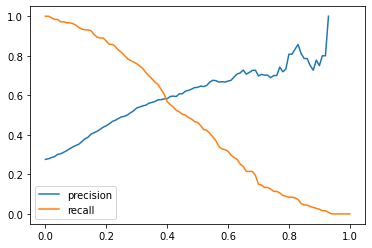

In [83]:
plt.plot(df_scores.threshold, df_scores['precision'], label='precision')
plt.plot(df_scores.threshold, df_scores['recall'], label='recall')
plt.legend()

## Question 4

In [88]:
scores_f1 = {}

thresholds = np.arange(0.0, 1.01, 0.01)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    p =  tp / (tp + fp)
    r = tp / (tp + fn)
    f1 = 2 * ((p * r) / (p+r))
    
    scores_f1[round(t, 3)] =  round(f1, 3)

<ipython-input-88-72df8a0930f9>:18: RuntimeWarning: invalid value encountered in long_scalars
  p =  tp / (tp + fp)


In [96]:
max(scores_f1, key=scores_f1.get)

0.3

In [97]:
scores_f1[0.3]

0.629

## Question 5

In [102]:
columns_to_use = ['seniority', 'income', 'assets', 'records', 'job', 'home']

In [103]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[columns_to_use].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [104]:
def predict(df, dv, model):
    dicts = df[columns_to_use].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [106]:
from sklearn.model_selection import KFold

In [107]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores_kfold = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.default.values
    y_val = df_val.default.values

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores_kfold.append(auc)

In [108]:
scores_kfold

[0.8256212256212256,
 0.8254176350237372,
 0.7893383818254285,
 0.8250108084738436,
 0.8054696294614563]

In [112]:
np.std(scores_kfold)

0.014611424893554475

## Question 6

In [114]:
for C in [0.01, 0.1, 1, 10]:
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)

    scores_kfold2 = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.default.values
        y_val = df_val.default.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores_kfold2.append(auc)

    print('C=%s ,mean=%.3f ,std=%.3f' % (C, np.mean(scores_kfold2), np.std(scores_kfold2)))

C=0.01 ,mean=0.808 ,std=0.012
C=0.1 ,mean=0.813 ,std=0.014
C=1 ,mean=0.814 ,std=0.015
C=10 ,mean=0.814 ,std=0.015
